In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
# Load your dataset
df = pd.read_csv('data.csv')

In [3]:
# Data exploration and analysis
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Age                             10000 non-null  int64 
 1   Education_Level                 10000 non-null  object
 2   Occupation                      10000 non-null  object
 3   Number_of_Dependents            10000 non-null  int64 
 4   Location                        10000 non-null  object
 5   Work_Experience                 10000 non-null  int64 
 6   Marital_Status                  10000 non-null  object
 7   Employment_Status               10000 non-null  object
 8   Household_Size                  10000 non-null  int64 
 9   Homeownership_Status            10000 non-null  object
 10  Type_of_Housing                 10000 non-null  object
 11  Gender                          10000 non-null  object
 12  Primary_Mode_of_Transportation  10000 non-null 

,Age,Number_of_Dependents,Work_Experience,Household_Size,Income
count,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04
mean,44.021700,2.527000,24.858800,3.989600,8.168382e+05
std,15.203998,1.713991,14.652622,2.010496,1.821089e+06
min,18.000000,0.000000,0.000000,1.000000,3.104400e+04
25%,31.000000,1.000000,12.000000,2.000000,6.844600e+04
50%,44.000000,3.000000,25.000000,4.000000,7.294300e+04
75%,57.000000,4.000000,37.000000,6.000000,3.506675e+05
max,70.000000,5.000000,50.000000,7.000000,9.992571e+06


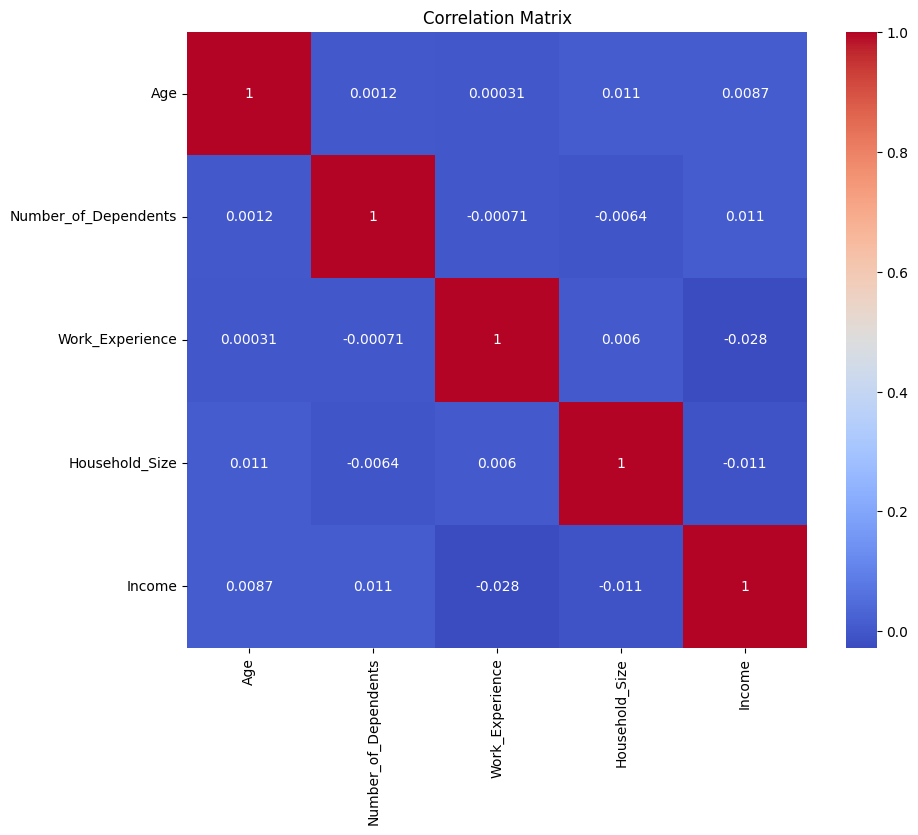

In [4]:
# Correlation matrix for numeric columns only
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

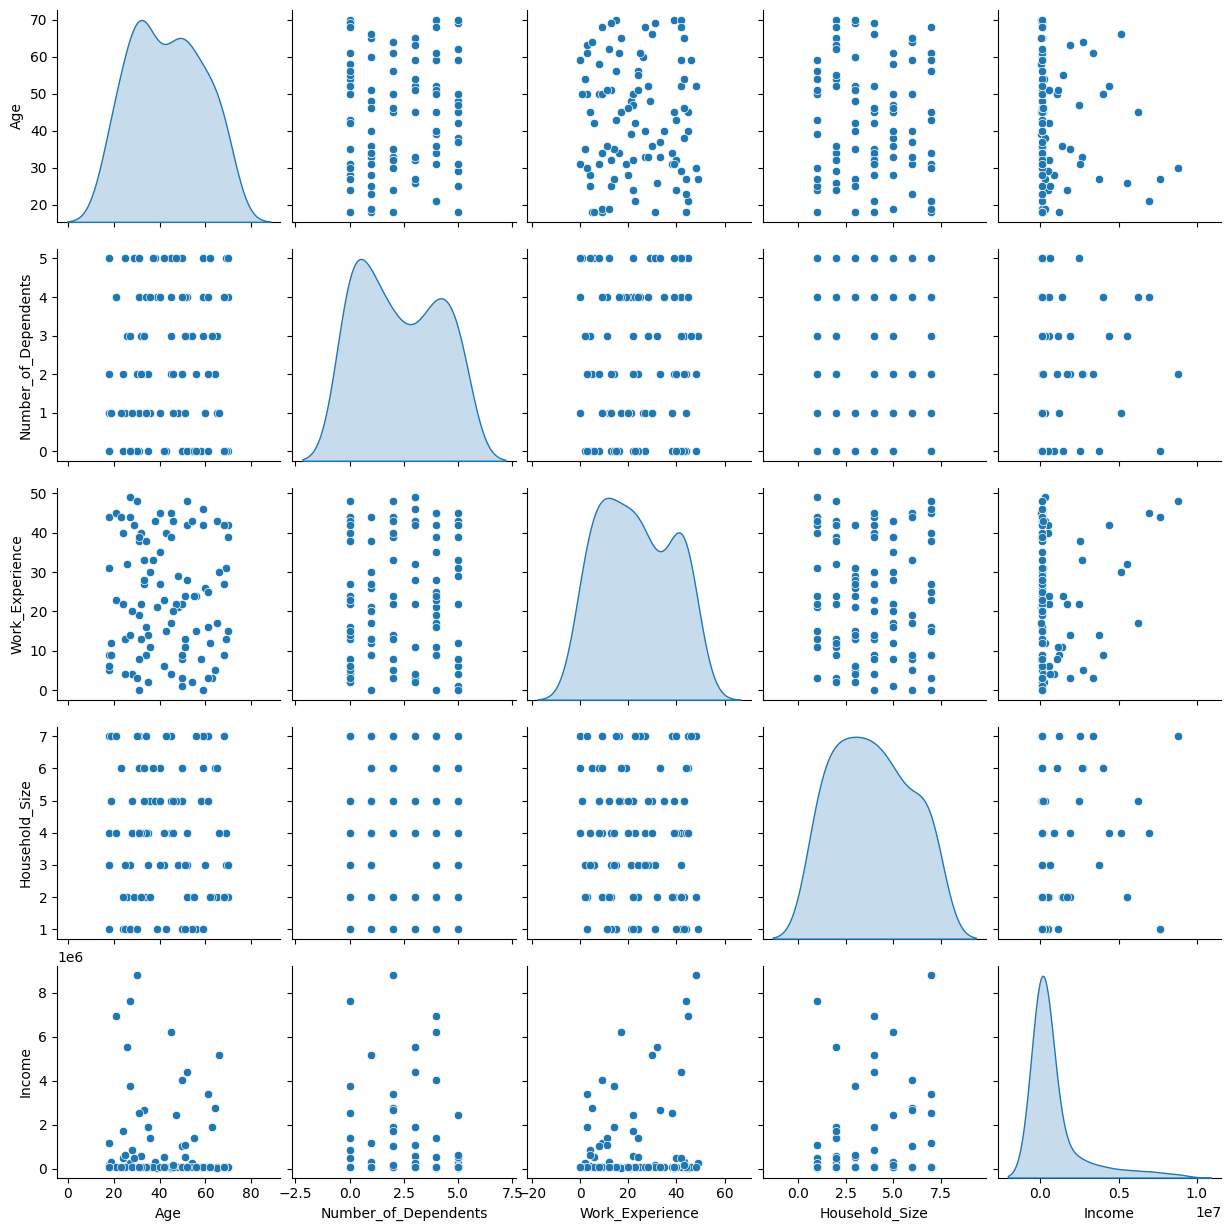

In [5]:
# Pairplot for visualizing relationships (using a subset to avoid overloading the plot)
sns.pairplot(df.sample(min(100, len(df))), diag_kind='kde')
plt.show()

In [6]:
# Filter the dataset to include only households with incomes up to 500,000 USD
df = df[df['Income'] <= 500000]

In [7]:
# Data preprocessing
X = df.drop('Income', axis=1)
y = df['Income']

# Encode categorical variables if needed (e.g., one-hot encoding for categorical features)
X = pd.get_dummies(X)

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA to training and test sets
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"Original number of features: {X_train_scaled.shape[1]}")
print(f"Reduced number of features after PCA: {X_train_pca.shape[1]}")

# Define the Keras model
def build_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_pca.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer for regression, no activation function
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Perform k-fold cross-validation on the training set
kf = KFold(n_splits=5, shuffle=True, random_state=0)
fold = 1
rmse_scores = []
r2_scores = []

for train_index, val_index in kf.split(X_train_pca):
    X_train_kf, X_val = X_train_pca[train_index], X_train_pca[val_index]
    y_train_kf, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Build and train the model
    model = build_model()
    history = model.fit(X_train_kf, y_train_kf, epochs=50, batch_size=8, verbose=0, validation_data=(X_val, y_val))
    
    # Evaluate the model on the validation set
    predictions = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    r2 = r2_score(y_val, predictions)
    print(f"Fold {fold} - Validation RMSE: {rmse:.2f}, Validation R^2: {r2:.2f}")
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    
    fold += 1

Original number of features: 33
Reduced number of features after PCA: 23
Fold 1 - Validation RMSE: 80154.16, Validation R^2: 0.01
Fold 2 - Validation RMSE: 76890.26, Validation R^2: 0.03
Fold 3 - Validation RMSE: 80179.50, Validation R^2: 0.04
Fold 4 - Validation RMSE: 76257.93, Validation R^2: 0.04
Fold 5 - Validation RMSE: 76964.23, Validation R^2: 0.04


In [8]:
# Calculate average scores across folds
avg_rmse = np.mean(rmse_scores)
avg_r2 = np.mean(r2_scores)
print(f"\nAverage Validation RMSE: {avg_rmse:.2f}, Average Validation R^2: {avg_r2:.2f}")


Average Validation RMSE: 78089.22, Average Validation R^2: 0.03


In [9]:
# Evaluate the final model on the test set
final_model = build_model()
final_model.fit(X_train_pca, y_train, epochs=50, batch_size=8, verbose=0)
test_predictions = final_model.predict(X_test_pca)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)
print(f"\nTest RMSE: {test_rmse:.2f}, Test R^2: {test_r2:.2f}")


Test RMSE: 68662.99, Test R^2: 0.05
